# Un modello di previsione per il mercato immobiliare

RealEstateAI Solutions si propone di ottimizzare la valutazione dei prezzi immobiliari attraverso l'uso di tecniche avanzate di regolarizzazione in modelli di regressione lineare. L'obiettivo è fornire previsioni di prezzo più accurate e affidabili, riducendo il rischio di overfitting e migliorando la capacità di generalizzazione del modello.

Nel settore immobiliare, ottenere stime precise dei prezzi delle proprietà è cruciale per prendere decisioni informate. Tuttavia, i modelli di regressione lineare tradizionali possono soffrire di overfitting, compromettendo l'accuratezza delle previsioni. È necessario esplorare metodi di regolarizzazione efficaci per migliorare le performance predittive e gestire la complessità del modello.

Implementando e confrontando metodi di regolarizzazione come Lasso, Ridge e Elastic Net, RealEstateAI Solutions offrirà un sistema in grado di fornire previsioni di prezzo immobiliari più accurate e stabili. Questo permetterà agli agenti immobiliari e agli investitori di prendere decisioni basate su dati più affidabili, aumentando la loro competitività nel mercato.

Il dataset è disponibile qui: https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv

Contiene i seguenti campi
- Price: il prezzo, il target da prevedere
- Area: superficie dell’immobile
- Bedrooms: numero di camere da letto
- Bathrooms: numero di bagni
- Stories: numero di piani
- Mainroad: vale 1 se l’immobile affaccia su una strada principale, 0 altrimenti
- guestroom: vale 1 se l’immobile ha una stanza degli ospiti, 0 altrimenti
- basement: vale 1 se l’immobile ha un seminterrato, 0 altrimenti
- hotwaterheating: vale 1 se l’immobile ha una caldaia, 0 altrimenti
- airconditioning: vale 1 se l’immobile ha l’aria condizionata, 0 altrimenti
- parking: numero di parcheggi
- prefarea: vale 1 se l’immobile è in una zona prestigiosa, 0 altrimenti
- Furnishingstatus: vale 0 se l’immobile non è arredato, 1 se è parzialmente arredato, 2 se è completamente arredato

## 1. Importazione delle librerie

Di seguito vi è una breve spiegazione delle librerie importate per il progetto:

* **Pandas**, usata per manipolare e analizzare dati strutturati (DataFrame, tabelle).
* **NumPy**, fondamentale per operazioni numeriche e matriciali.
* **Statsmodels**, per modelli statistici  e test.

* **Matplotlib**, libreria base per creare grafici per la visualizzazione dei dati.
* **Seaborn**, costruita su Matplotlib, per visualizzazioni statistiche più avanzate e stilizzate.
* **Scikit-learn**, libreria di per il machine learning:
> * **sklearn.linear_model** modulo che contiene le classi per istanziare imodelli di regressione lineare.
> * **sklearn.metrics**, modulo che contiene metriche per valutare i modelli di regressione.
> * **sklearn.model_selection**, modulo che fornisce gli strumenti per la validazione incrociata, la divisione del dataset, e la ricerca dei parametri ottimali.
> * **sklearn.preprocessing**`: modulo con tutti gli strumenti per il preprocessing dei dati necessario per l'allenamento dei modelli, tra i quali la standardizzazione.
> * **sklearn.pipeline**: modulo per combinare più passaggi in un unico flusso attraverso la creazione di Pipeline.
> * **sklearn.compose**: modulo con strumenti per effettuare trasformazioni dei dati.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

## 2. Caricamento e analisi dei dati

In questa sezione viene caricato il dataset descritto nell'introduzione, che servirà per allenare i modelli di regressione. Verrà effettuata un'analisi dettagliata del dataset tramite le funzioni della libreria `pandas`.

In [2]:
# url del dataset
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"

# caricamento del dataset in un Dataframe di Pandas
df = pd.read_csv(DATASET_URL)

# Stampa i primi dieci risultati
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


In [3]:
# Verifica del tipo di ogni variabile
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


In [4]:
# Analisi statistica delle variabili
df.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.858716,0.177982,0.350459,0.045872,0.315596,0.693578,0.234862,1.089908
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.348635,0.382849,0.477552,0.209399,0.465180,0.861586,0.424302,0.858130
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000


In [5]:
# Calcolo della matrice di correlazione
corr_matrix = df.corr()
corr_matrix

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394,0.329777,0.190086
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,0.081367
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,0.097834
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,0.089418
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,0.043288
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,0.079403
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,0.057513
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,0.093425
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,0.069076
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,0.020887


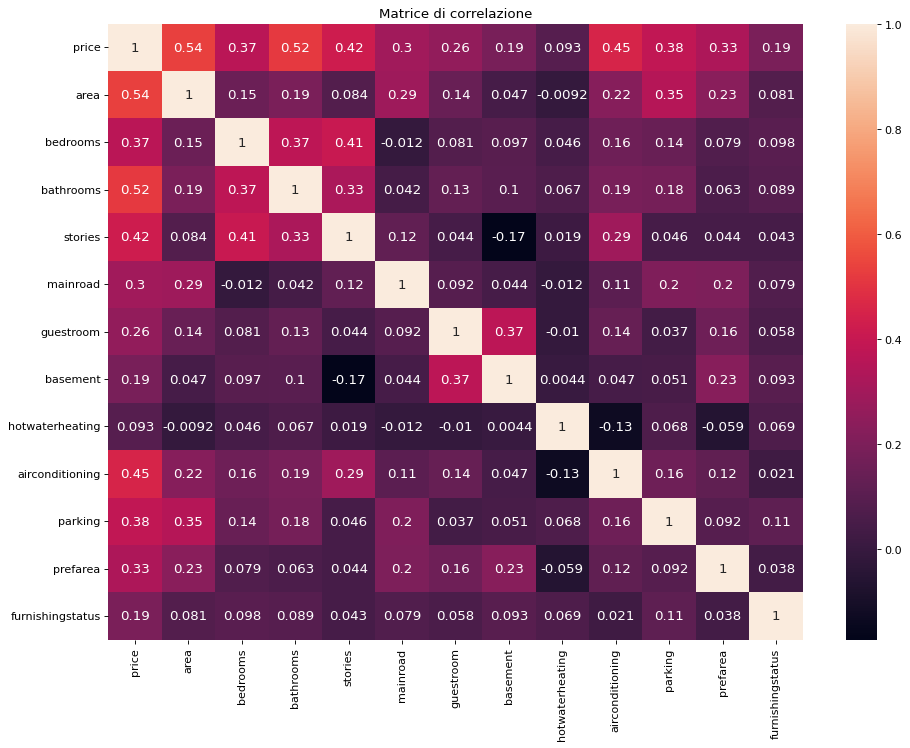

In [6]:
# Impostazione delle dimensioni della figura
fig, ax = plt.subplots(figsize=(14, 10), dpi=80) 

# Visualizzazione della matrice di correlazion con una heatmap
sns.heatmap(corr_matrix, annot=True, xticklabels=df.columns, yticklabels=df.columns, annot_kws={'size': 12})

# Titolo del grafico
plt.title('Matrice di correlazione')
plt.show()

### 2.1 Correlazione con il target
Nessuna variabile ha una correlazione forte con la variabile target. Le variabili marggiomente collegate con il target hanno correlazione moderata e positiva:

- **area** (0.54)
- **bathrooms** (0.52)
- **airconditioning** (0.45)
- **stories** (0.42)

Successivamente abbiamo le feature con correlazione debole (anche qui sempre positiva):

- **parking** (0.38)
- **bedrooms** (0.37)
- **prefarea** (0.33)
- **mainroad** (0.3)
- **guestroom** (0.26)

Rimangono infine quelle con correlazione molto debole (anche qui sempre positiva):

- **furnishingstatus** (0.19)
- **basement** (0.19)
- **hotwaterheating** (0.093)

### 2.2 Correlazione tra le variabili

Una coppia di variabilia ha correlazione moderata positiva: **stories** e **bedrooms** (0.41).

Ci sono poi delle correlazioni deboli (tutte positive):
- **bathrooms** e **bedrooms** (0.37)
- **basement** e **guestroom** (0.37)
- **parking** e **area** (0.35)
- **stories** e **bedrooms** (0.33)

Le altre coppie di variabili hanno correlazione debole, tra le quali troviamo le uniche correlazioni negative:
- **basement** e **stories** (-0.17)
- **airconditioning** e **hotwaterheating** (-0.13)
- **prefarea** e **hotwaterheating** (-0.059)

In generale non vi è un'altissima correlazione con la variabile target e le correlazioni tra le variabili sono prevalentemente deboli quindi non dovrebbe esserci un grande rischio di collinearità. Tutte le feature possono quindi contribuire a migliorare il modello di regressione.

### 2.3 Analisi variabile target

In questa sezione calcoleremo l'ordine di grandezza della variabile target. Questo passaggio è utile perché, quando i prezzi presentano valori molto elevati, può essere opportuno scarlarli a un ordine di grandezza più basso. Tale operazione risulta particolarmente vantaggiosa per algoritmi di apprendimento basati sull’ottimizzazione tramite gradiente, come la regressione lineare, poiché migliora la stabilità numerica e accelera la convergenza durante la fase di allenamento.

Il seguente codice calcola il logaritmo in base 10 dei prezzi con la funzione `np.log10`, per calcolare il logaritmo in base 10 dei prezzi, così da identificare l’ordine di grandezza di ciascun valore, ovvero a quale potenza del 10 esso corrisponde. Successivamente, la funzione `np.floor` viene applicata per approssimare ogni risultato all’intero inferiore più vicino, consentendo così di classificare i prezzi in base all’intervallo di grandezza cui appartengono (ad esempio 10^4, 10^5, ecc.). Tra le potenze calolate viene poi ricavato il valore minimo tramite la funzione `np.min`.

In [7]:
# Calcolo degli ordini di grandezza dei prezzi
order_of_magnitude = np.floor(np.log10(df['price']))

# Ricerca della variabile target
print(f"Ordine di grandezza minimo: {order_of_magnitude.min()}")

Ordine di grandezza minimo: 6.0


Poiché l'ordine di grandezza minimo è 6, in fase di preprocessing tutti i valori del prezzo verrano divisi per 10^6.

## 3. Prepocessing

In questa sezione viene effettuato il preprocessing dei dati, un processo che prepara e trasforma i dati grezzi in un formato adatto per l’addestramento dei modelli di machine learning. Questo include operazioni come la gestione dei valori mancanti, la normalizzazione o standardizzazione delle feature numeriche, la codifica delle variabili categoriche, la rimozione di outlier e la suddivisione del dataset in set di training e test. L’obiettivo è migliorare la qualità dei dati affinché il modello possa apprendere in modo efficace e generare previsioni più accurate.

### 3.1 Gestione valori mancanti

In [8]:
# Dimensione del dataset
df.shape[0]

545

In [9]:
# Conteggio dei valori validi per ogni feature
df.count()

price               545
area                545
bedrooms            545
bathrooms           545
stories             545
mainroad            545
guestroom           545
basement            545
hotwaterheating     545
airconditioning     545
parking             545
prefarea            545
furnishingstatus    545
dtype: int64

In [10]:
# Conteggio dei valori nulli per feature
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Nessuna feature ha dei valori nulli o non validi. Perciò, il dataset non richiede operazioni sui dati mancanti.

### 3.2 Codifica variabili categoriche

Molti algoritmi non possono lavorare direttamente con dati categorici. Questi ultimi vanno quindi trasformati in formato numerico per renderli comprensibili ai modelli di machine learning. Nel caso di valori categorici come `furnishingstatus`, si usa la tecnica del **one-hot encoding**.
Il one-hot encoding funziona creando una nuova colonna binaria (0 o 1) per ciascuna categoria presente nella variabile originale: ogni riga avrà un valore pari a 1 solo nella colonna corrispondente alla propria categoria, e 0 in tutte le altre. Questo metodo evita che i modelli attribuiscano relazioni ordinali errate tra le categorie, cosa che accadrebbe se venissero assegnati numeri interi semplici.

In [11]:
# Uso del One-hot encoding sulla variabile categorica scorrelata "furnishingstatus"
df = pd.get_dummies(df, columns=['furnishingstatus'], prefix="furnishingstatus", prefix_sep="_", dtype=int)

In [12]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_0,furnishingstatus_1,furnishingstatus_2
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,1,0


### 3.3 Hold-out del dataset

Il dataset viene diviso in training e test set al fine di valutare se i modelli di regressione che verranno allenati soffrono di overfitting.

In [13]:
# Divisione tra features e variabile target

X = df.drop(columns=['price'])
y = df['price']

In [14]:
# Impostazione del random seed per garantire la riproducibilità
RANDOM_SEED = 42

In [15]:
# Divisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

In [16]:
print(f"Dimensione training set: {y_train.shape}")
print(f"Dimensione test set: {y_test.shape}")

Dimensione training set: (381,)
Dimensione test set: (164,)


### 3.4 Standardizzazione

Dall'analisi fatta al punto 2, risulta che il dataset contiene features su scale molto diverse. In particolare, **area** è su una scala sull'ordine delle migliaia, mentre **bedrooms**, **bathrooms**, **stories** e **parking** hanno valori piccoli. Perciò, un modello di regressione lineare darebbe molta più importanza a questa feature rispetto alle altre. L'applicazione di una tecnica di scaling risulta quindi necessaria.

L'attributo **area** ha inoltre un valore massimo (16200) lontano dalla mediana (4600), indicando quindi la presenza di potenziali outlier. La normalizzazione ne risentirebbe schiacciando i valori vicini alla mediana verso lo 0. La standardizzazione è quindi da preferirsi, anche per il fatto che, nel caso regressione lineare, features a media 0 e varianza 1 accelerano la convergenza nell'algoritmo di discesa del gradiente.

In [17]:
# Selezione delle colonne a cui applicare la standardizzazione 
to_std = ["area", "bedrooms", "bathrooms", "stories", "parking"]

In [18]:
# Istanziamento dello scaler
ss = StandardScaler()

In [19]:
# Standardizzazione delle features selezionate
X_train[to_std] = ss.fit_transform(X_train[to_std])

# Applicazione della stessa standardizzazione al test set
X_test[to_std] = ss.transform(X_test[to_std])

In [20]:
X_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_0,furnishingstatus_1,furnishingstatus_2
126,0.934301,0.055861,-0.553238,-0.907660,1,0,1,0,0,1.591603,1,1,0,0
363,-0.710246,-1.274325,-0.553238,-0.907660,1,0,0,1,0,-0.800511,0,0,0,1
370,-0.390167,-1.274325,-0.553238,-0.907660,1,0,0,0,1,1.591603,0,0,0,1
31,0.860719,0.055861,-0.553238,2.573733,1,0,0,0,1,1.591603,0,0,0,1
113,2.065617,0.055861,-0.553238,-0.907660,1,0,1,0,0,1.591603,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.400835,1.386046,1.554599,2.573733,1,0,0,0,1,-0.800511,0,1,0,0
106,0.147898,1.386046,1.554599,-0.907660,1,0,1,0,1,-0.800511,1,0,0,1
270,-0.288992,0.055861,1.554599,1.413269,1,0,0,1,0,0.395546,0,0,1,0
435,-0.500539,-1.274325,-0.553238,-0.907660,1,0,0,0,0,-0.800511,0,1,0,0


### 3.5 Scaling della variabile target

Come anticipato nella sezione 2.3, i valori della variabile target vengono scalati a un ordine di grandezza più piccolo per garantire stabilità numerica.

In [21]:
y_train = y_train / 10**6
y_test = y_test / 10**6

## 4. Modelli di regressione Lineare

Nella seguente sezione verrano allenati e testati i modelli di regressione lineare. Si partirà da un modello semplice per misurarne le prestazioni e valutare l'eventuale la necessità di applicazione di tecniche di regolarizzazione per contrastare l'overfitting.

In [22]:
# La seguente funzione valuta le performance di un modello di regressione lineare su un dataset, stampando due metriche: 
# score r2 e l'errore quadratico medio

def evaluate_model(model, dataset):
    X, y = dataset

    y_pred = model.predict(X)

    print(f"R2: {r2_score(y, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y, y_pred):.3f}")

### 4.1 Regressione lineare semplice

In [23]:
# Istanziamento del modello di regressione lineare
lr = LinearRegression()

# Allenamento del modello
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
# Performance sul training set
evaluate_model(lr, (X_train, y_train))

R2: 0.693
MSE: 0.964


In [25]:
# Performance sul test set
evaluate_model(lr, (X_test, y_test))

R2: 0.646
MSE: 1.523


| Metrica           | Training Set | Test Set    |
|-------------------|--------------|-------------|
| **R2**            | 0,693        | 0,646       |
| **MSE**           | 0,964        | 1,523       |

Il **R2** indica che circa il 69.3% della variabilità dei dati nel training set è spiegato dal modello, il che è un buon risultato. Il modello presenta un errore quadratico medio significativo. Nel test set, il **R2** diminuisce a 0,646 e l'errore quadratico medio aumenta rispetto al training set anche se non di molto. Questo suggerisce la presenza di un leggero overfitting.

### 4.2 Regressione Lineare con Regolarizzazione Ridge

In questa sezione verrà implementato un modello di regressione Ridge (L2), la quale aggiunge un termine di penalizzazione proporzionale alla somma dei quadrati dei coefficienti per penalizzare i coefficienti grandi, riducendo così la possibilità di overfitting. L'intensità è regolata tramite un iperparametro, che nel caso della funzione `Ridge()` di scikit-learn è chiamato `alpha`.

La regressione Ridge caratterizzata dalla un paramentro alpha che regola l'intensità della regolarizzazione. Per scegliere il valore migliore di alpha ricorriamo alla funzione di scikit-learn `GridSearchCV()`, che automatizza la ricerca dei migliori iperparametri per un modello di machine learning. 
La funzione segue una ricerca esaustiva su una griglia predefinita di valori per uno o più iperparametri. Per ogni combinazione possibile, il modello viene addestrato e valutato utilizzando la cross-validation. In questo caso, l'unico parametro da valutare è `alpha` e si ricerca il valore che minimizzi l'errore quadratico medio, assegnando il valore `neg_mean_squared_error` al parametro `scoring` della funzione.

In [26]:
# Possibili valori di alpha
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Utilizzo della GridSearch per la ricerca del parametro migliore
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Alpha ottimale selezionato
print("Alpha ottimale:", grid_search.best_params_['alpha'])

Alpha ottimale: 10


In [27]:
alpha = 10.0

In [28]:
ridge = Ridge(alpha=alpha)

In [29]:
ridge.fit(X_train, y_train)

Ridge(alpha=10.0)

In [30]:
evaluate_model(ridge, (X_train, y_train))

R2: 0.692
MSE: 0.969


In [31]:
evaluate_model(ridge, (X_test, y_test))

R2: 0.638
MSE: 1.559


| Metrica           | Training Set | Test Set    |
|-------------------|--------------|-------------|
| **R2**            | 0,692        | 0,638       |
| **MSE**           | 0,   969     | 1,559       |

I valori di R2 e MSE sono simili a quelli della regressione lineare, con una leggera perdita di accuratezza.

### 4.3 Regressione Lineare con Regolarizzazione Lasso

In questa sezione verrà implementato un modello di regressione Lasso (L1), la quale aggiunge un termine di penalizzazione proporzionale alla somma dei valori assoluti dei coefficienti per penalizzare i coefficienti grandi. A differenza della penalizzazione di Ridge, Lasso può portare i coefficienti a zero operando una vera e propria selezione delle features. L'intensità della regolarizzazione è sempre controllata da un parametro chiamato `alpha` nella funzione `Lasso()` di scikit-learn.

Come per la regressione Ridge, tramite la Grid Search Cross Validation viene selezionato il miglior valore per alpha.

In [32]:
# Possibili valori di alpha
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Utilizzo della GridSearch per la ricerca del parametro migliore
grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Alpha ottimale selezionato
print("Alpha ottimale:", grid_search.best_params_['alpha'])

Alpha ottimale: 0.01


L'output mostra una mancata convergenza per i valori di alpha più piccoli. Si è provato ad aumentare il numero di iterazioni di Lasso di alcuni ordini di grandezza (10000, 100000, ecc) o ad aumentare la tolleranza ma questo non ha sortito alcun effetto, motivo per cui questi tentativi sono stati omessi dal progetto.

In [33]:
alpha = 0.01

In [34]:
lasso = Lasso(alpha=alpha)

In [35]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

In [36]:
evaluate_model(lasso, (X_train, y_train))

R2: 0.692
MSE: 0.968


In [37]:
evaluate_model(lasso, (X_test, y_test))

R2: 0.639
MSE: 1.553


| Metriche          | Training Set | Test Set    |
|-------------------|--------------|-------------|
| **R2**            | 0,692        | 0,639       |
| **MSE**           | 0,968        | 1,553       |

In questo caso si registrano valori molto simili a quelli della regressione Ridge, con le stesse variazioni tra training e test set.

### 4.4 Regressione Lineare di tipo Elastic Net

Elastic Net è una tecnica di regolarizzazione che combina le penalizzazioni Lasso (L1) e Ridge (L2). Questo metodo utilizza due iperparametri: `alpha`, che determina l'intensità complessiva della regolarizzazione, e `l1_ratio`, che regola il bilanciamento tra L1 e L2. In particolare, `l1_ratio = 1` corrisponde a una penalizzazione puramente Lasso, `l1_ratio = 0` a una penalizzazione esclusivamente Ridge, mentre un valore intermedio come `l1_ratio = 0.5` assegna lo stesso peso a entrambe.

In [38]:
# Possibili valori di alpha
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100], "l1_ratio": [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]}

# Utilizzo della GridSearch per la ricerca del parametro migliore
grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

print("Alpha ottimale:", grid_search.best_params_)

Alpha ottimale: {'alpha': 0.01, 'l1_ratio': 0.1}


In [39]:
alpha = 0.1
l1_ratio = 0.1

In [40]:
elasticnet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

In [41]:
elasticnet.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.1)

In [42]:
evaluate_model(elasticnet, (X_train, y_train))

R2: 0.680
MSE: 1.007


In [43]:
evaluate_model(elasticnet, (X_test, y_test))

R2: 0.618
MSE: 1.647


| Metriche          | Training Set | Test Set    |
|-------------------|--------------|-------------|
| **R2**            | 0,680        | 0,618       |
| **MSE**           | 1,007        | 1,647       |

Si registra un discreto peggioramento delle performance rispetto a Lasso e Ridge, con un MSE maggiore di 1 sul training set. 

### 4.5 Confronto delle performance

In questa sezione verranno confrontati direttamente le performance dei modelli con due istogrammi, uno per R2 e uno per MSE, creati con la libreria `matplotlib` attraverso la funzione `bar`. 

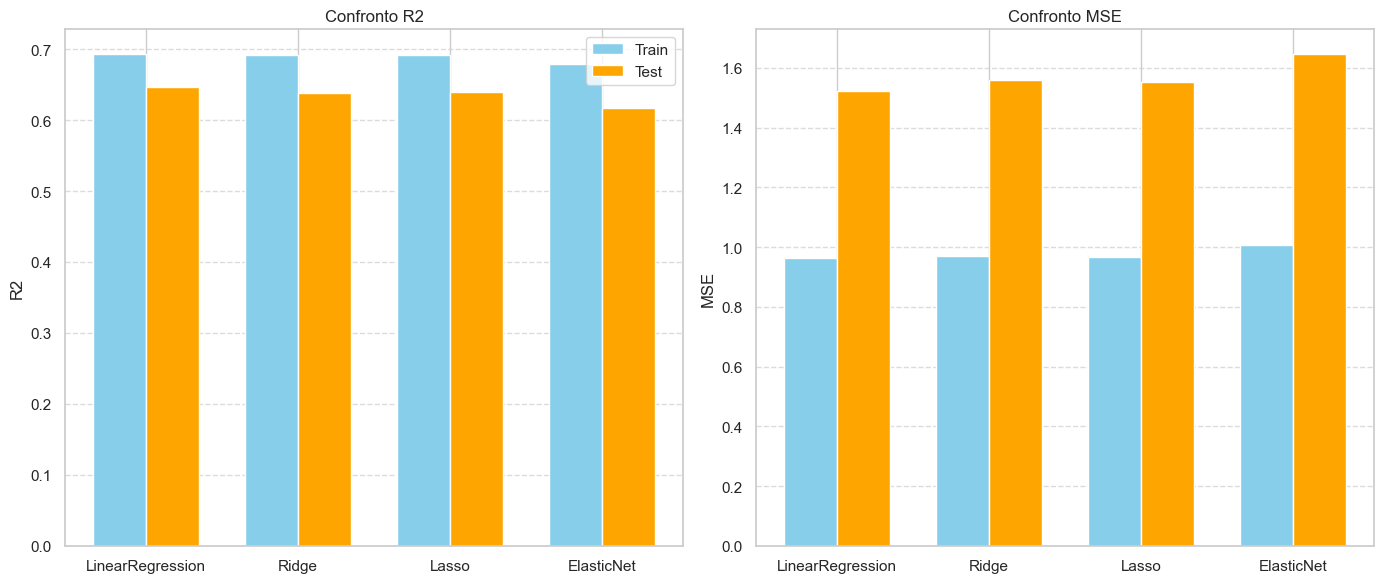

In [44]:
models = {
    "LinearRegression": lr,
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": elasticnet
}

# Valori di R2
r2_train = [r2_score(y_train, model.predict(X_train)) for model in list(models.values())]
r2_test = [r2_score(y_test, model.predict(X_test)) for model in list(models.values())]

# Valori di MSE
mse_train = [mean_squared_error(y_train, model.predict(X_train)) for model in list(models.values())]
mse_test = [mean_squared_error(y_test, model.predict(X_test)) for model in list(models.values())]

# Imposta il tema di Seaborn
sns.set_theme(style="whitegrid")

# Posizioni delle barre
x = np.arange(len(models))
width = 0.35  # Larghezza delle barre

# Creazione dei due grafici
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Grafico R2
# Barra per il training set
axs[0].bar(x - width/2, r2_train, width, label='Train', color='skyblue')
# Barra per il test set
axs[0].bar(x + width/2, r2_test, width, label='Test', color='orange')
# Etichetta per ordinate
axs[0].set_ylabel('R2')

# Titolo del grafico
axs[0].set_title('Confronto R2')
axs[0].set_xticks(x)

# I nomi dei modelli vengono messi sull'asse delle ascisse
axs[0].set_xticklabels(models)
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Grafico MSE
# Barra per il training set
axs[1].bar(x - width/2, mse_train, width, label='Train', color='skyblue')

# Barra per il test set
axs[1].bar(x + width/2, mse_test, width, label='Test', color='orange')
axs[1].set_ylabel('MSE')
axs[1].set_title('Confronto MSE')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Dagli istogrammi emerge che le performance dei modelli sono comparabili, sia nel training set che nel test set. R2 in particolare non registra nessuna variazione significativa tra i quattro modelli mentre il MSE registra valori migliori per la regressione semplice e Lasso registrano un MSE più basso, leggermente migliore quello della regressione semplice. Ciò suggerisce che i dati presenti nel dataset non presentano problemi significativi di collinearità e overfitting tali da richiedere l'applicazione tecniche di regolarizzazione.

## 5. Cross-Validation

L'applicazione della cross-validation mira ottenere una valutazione più robusta dei quattro modelli, testandoli su più suddivisioni dei dati al fine di ottenere una valutazione più stabile e rappresentativa delle reali capacità del modello.

### 5.1 K-Fold cross-validation

Il metodo più comune per la cross-validation è la K-Fold Cross-Validation. Consiste nel creare k sottoinsiemi (fold) del dataset di dimensioni simili. Il modello viene addestrato su k-1 fold e testato sul fold rimanente. Questo processo viene ripetuto k volte, ogni volta utilizzando un fold diverso come set di test. Infine, le prestazioni vengono mediate per ottenere una stima più robusta.

Si sceglie di implementare manualmente la K-Fold cross-validation poiché per ogni fold è necessario applicare la standardizzazione solo per le features continue. Scikit-learn mette a disposizione la classe `KFold` per creare in automatico i fold.

In [45]:
# La classe viene inizializzata per creare 5 fold e impostata per mescolare i dati prima di creare i fold.
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [46]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=10),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = []

for name, model in models.items():

    r2_train_scores = []
    r2_test_scores = []
    mse_train_scores = []
    mse_test_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
    
        ss = StandardScaler()
        # Standardizzazione delle features selezionate
        X_train[to_std] = ss.fit_transform(X_train[to_std])
        
        # Applicazione della stessa standardizzazione al test set
        X_test[to_std] = ss.transform(X_test[to_std])

        y_train = y_train / 10**6
        y_test = y_test / 10**6
    
        model.fit(X_train, y_train)
    
        r2_train = r2_score(y_train, model.predict(X_train))
        r2_test = r2_score(y_test, model.predict(X_test))
    
        mse_train = mean_squared_error(y_train, model.predict(X_train))
        mse_test = mean_squared_error(y_test, model.predict(X_test))
    
        r2_train_scores.append(r2_train)
        r2_test_scores.append(r2_test)
        mse_train_scores.append(mse_train)
        mse_test_scores.append(mse_test)

    results.append({
                    "model": name,
                    "train R2 mean": np.mean(r2_train_scores),
                    "train R2 std": np.std(r2_train_scores),
                    "test R2 mean": np.mean(r2_test_scores),
                    "test R2 std": np.std(r2_test_scores),
                    "train MSE mean": np.mean(mse_train_scores),
                    "train MSE std": np.std(mse_train_scores),
                    "test MSE mean": np.mean(mse_test_scores),
                    "test MSE std": np.std(mse_test_scores),
                    })


### 5.2 Confronto delle performance

In questa sezione verranno confrontati direttamente le performance dei modelli con due istogrammi, uno per R2 e uno per MSE, creati con la libreria `matplotlib` attraverso la funzione `bar`. Ciascun istogramma sarà composto dai valori medi di R2 e MSE registrati da ogni modello di regressione su tutti i fold con due barre per ciascun modello, una per il training set e una per il test set. mettendo in evidenza anche la deviazione standard con una linea nera su ogni barra dell'istogramma, tramite l'impostazione del parametro `yerr`.

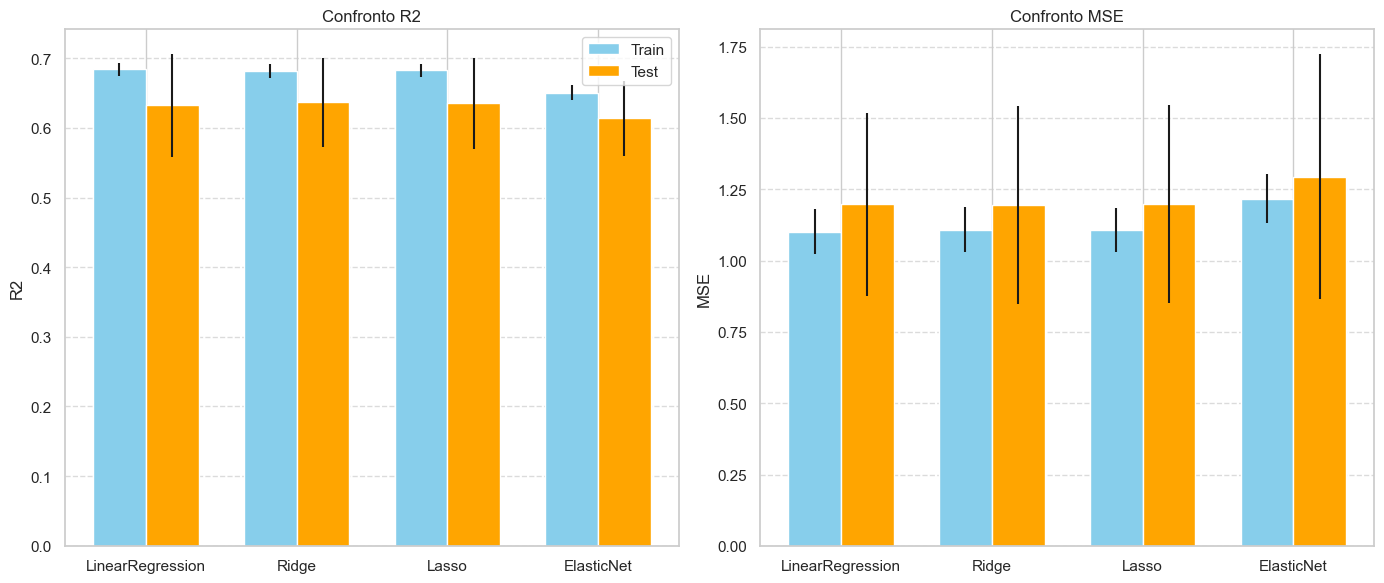

In [47]:
# Example data
models = [el["model"] for el in results]
train_r2_mean = [el["train R2 mean"] for el in results]
train_r2_std = [el["train R2 std"] for el in results]
test_r2_mean = [el["test R2 mean"] for el in results]
test_r2_std = [el["test R2 std"] for el in results]

train_mse_mean = [el["train MSE mean"] for el in results]
train_mse_std = [el["train MSE std"] for el in results]
test_mse_mean = [el["test MSE mean"] for el in results]
test_mse_std = [el["test MSE std"] for el in results]

# Impostazione del tema
sns.set_theme(style="whitegrid")

# Posizioni delle barre
x = np.arange(len(models))
width = 0.35  # Larghezza delle barre

# Creazione del grafico
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Grafico R2

# Barra per il training set
axs[0].bar(x - width/2, train_r2_mean, width, yerr=train_r2_std, label='Train', color='skyblue')
# Barra per il test set
axs[0].bar(x + width/2, test_r2_mean, width, yerr=test_r2_std, label='Test', color='orange')
axs[0].set_ylabel('R2')
axs[0].set_title('Confronto R2')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Grafico MSE

# Barra per il training set
axs[1].bar(x - width/2, train_mse_mean, width, yerr=train_mse_std, label='Train', color='skyblue')
# Barra per il test set
axs[1].bar(x + width/2, test_mse_mean, width, yerr=test_mse_std, label='Test', color='orange')
axs[1].set_ylabel('MSE')
axs[1].set_title('Confronto MSE')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Gli istogrammi mettono in evidenza delle differenze minime tra i quattro modelli per i valori di R2 e di MSE, sia nel training set che nel test set. Tutti e quattro i modelli registrano maggiore stabilità sul training set per poi registrare un aumento della deviazione standard sul test set. Questo aumento della deviazione standard risulta però comparabile nel caso di tutti e quattro i modelli, con una maggiore stabilità per la regressione lineare semplice sui valori di MSE. Anche questa validazione suggerisce quindi la non necessità di tecniche di regolarizzazione su questo dataset.

## 6. Complessità dei modelli

In questa sezione viene esaminata la complessità dei modelli analizzando il numero di **coefficienti non nulli** per ognuno dei quattro modelli. I coefficienti rappresentano il peso di ciascuna variabile indipendente sul target. Tale analisi in un modello di regressione lineare è fondamentale per comprendere quali variabili indipendenti influenzano significativamente la variabile dipendente. 

I quattro modelli trattano i coefficienti in modo diverso:

* La regressione lineare semplice non applica penalizzazioni, per cui mantiene tutti i coefficienti (anche irrilevanti), rendendo il modello potenzialmente complesso e vulnerabile all'overfitting.
* La regressione Ridge aggiunge una penalizzazione che riduce i coefficienti ma non li azzera.
* La regressione Lasso, invece, applica una penalizzazione che può annullare completamente alcuni coefficienti, effettuando così una selezione automatica delle variabili.
* Elastic Net combina le due penalizzazioni di Ridge e Lasso, bilanciando la riduzione e l'eliminazione dei coefficienti. Anch'esso può quindi potenzialmente eliminare delle variabili.

Lasso ed Elastic Net possono quindi portare a dei modelli semplici tramite l'azzeramento dei alcuni coefficienti e la conseguente eliminazione delle rispettive variabili. La regressione lineare semplice e Ridge manterranno invece modelli con una maggiore complessità.

In [48]:
models = {
    "LinearRegression": lr,
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": elasticnet
}

coeff_counts = []

for name, model in models.items():

    coeff_count = {}

    # Prendiamo i coefficienti del modelli
    coefficients = model.coef_

    # Conteggio dei coefficienti non nulli in numero assoluto e in percentuale
    coeff_count["model"] = name
    coeff_count["sum non zero"] = np.sum(coefficients != 0)
    coeff_count["% non zero"] = (np.sum(coefficients != 0) / len(coefficients)) * 100

    coeff_counts.append(coeff_count)

    # Stampa dei coefficienti non nulli
    print(f"{name}:")
    print(f"- Numero totale di coefficienti non nulli: {coeff_count["sum non zero"]}")
    print(f"- Percentuale di coefficienti non nulli: {coeff_count["% non zero"]:.2f}%")
    
    print("\nCoefficienti non nulli:")
    
    # Stampa delle features corrispondenti ai coefficienti non nulli
    feature_names = list(X.columns)
    for i, coef in enumerate(coefficients):
        if coef != 0:
            print(f"- {feature_names[i]}: {coef:.2f}")


    # Stampa le features corrispondenti ai coefficienti nulli
    if coeff_count["sum non zero"] != X.shape[1]:
        print("\nCoefficienti nulli:")
        
        feature_names = list(X.columns)
        for i, coef in enumerate(coefficients):
            if coef == 0:
                print(f"- {feature_names[i]}")
            
    print("\n -----------------------------------------------\n")

LinearRegression:
- Numero totale di coefficienti non nulli: 14
- Percentuale di coefficienti non nulli: 100.00%

Coefficienti non nulli:
- area: 0.55
- bedrooms: 0.06
- bathrooms: 0.53
- stories: 0.36
- mainroad: 0.41
- guestroom: 0.28
- basement: 0.48
- hotwaterheating: 0.62
- airconditioning: 0.69
- parking: 0.25
- prefarea: 0.51
- furnishingstatus_0: -0.22
- furnishingstatus_1: 0.17
- furnishingstatus_2: 0.05

 -----------------------------------------------

Ridge:
- Numero totale di coefficienti non nulli: 14
- Percentuale di coefficienti non nulli: 100.00%

Coefficienti non nulli:
- area: 0.55
- bedrooms: 0.07
- bathrooms: 0.52
- stories: 0.36
- mainroad: 0.35
- guestroom: 0.27
- basement: 0.45
- hotwaterheating: 0.38
- airconditioning: 0.60
- parking: 0.26
- prefarea: 0.46
- furnishingstatus_0: -0.22
- furnishingstatus_1: 0.17
- furnishingstatus_2: 0.05

 -----------------------------------------------

Lasso:
- Numero totale di coefficienti non nulli: 13
- Percentuale di coeff

Come previsto, la regressione lineare semplice e il modello Ridge non annullano alcun coefficiente. Tuttavia, grazie alla penalizzazione, Ridge riduce sensibilmente l’ampiezza di molti coefficienti rispetto alla regressione semplice, contribuendo a limitare l’overfitting. Lasso ed ElasticNet hanno portato all’annullamento di una sola variabile, `furnishing_status_2`, suggerendo che le restanti variabili mantengono una correlazione significativa con la variabile target, e che quindi la complessità del modello non può essere ulteriormente ridotta in modo sostanziale. 
Le performance simili osservate tra i modelli nelle sezioni precedenti indicano che la lieve riduzione della complessità ottenuta con Lasso ed Elastic Net non comporta un impatto significativo sulle prestazioni.

## 7. Distribuzione dei residui

L'analisi dei residui è una componente fondamentale per valutare della qualità e dell'affidabilità di un modello di regressione lineare. Analizzarli permette di verificare le quattro assunzioni chiave della regressione lineare per determinare quanto bene il modello si adatti ai dati osservati.  

Le assunzioni chiave della regressione lineare sono:

1. **Linearità**: la relazione tra le variabili indipendenti e la variabile dipendente è lineare.
2. **Indipendenza**: i residui sono indipendenti tra loro.
3. **Omoschedasticità**: i residui hanno una varianza costante per tutti i valori delle variabili indipendenti.
4. **Normalità**: i residui seguono una distribuzione normale.

In [49]:
# Recupero dei modelli allenati e testati nelle sezioni precedenti
models = {
    "LinearRegression": lr,
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": elasticnet
}

Il codice seguente riprende il preprocessing della sezione 3.4 e 3.5 per riassegnare a X_test e y_test i valori della divisione iniziale con il preprocessing opportuno.

In [50]:
# Recupero della divisione originale del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# Scaling della variabile target
y_train = y_train / 10**6
y_test = y_test / 10**6

# Istanziamento dello scaler
ss = StandardScaler()

# Standardizzazione delle features selezionate
X_train[to_std] = ss.fit_transform(X_train[to_std])

# Applicazione della stessa standardizzazione al test set
X_test[to_std] = ss.transform(X_test[to_std])

### 7.1 Grafico dei residui

Il grafico che mette i residui in relazione con i valori predetti permette di verificare le seguenti ipotesi:

* **Linearità**. Se i residui sono distribuiti in modo casuale intorno alla linea zero senza mostrare alcun pattern sistematico (come una curva), ciò suggerisce che l'ipotesi di linearità è soddisfatta. Se invece si osservano pattern evidenti, ciò potrebbe indicare che il modello non è lineare.
* **Omoschedasticità**. Se i residui mostrano una varianza costante intorno alla linea zero per tutti i valori predetti, ciò suggerisce che l'ipotesi di omoschedasticità è soddisfatta. Se invece si osserva un pattern a "funnel" (dove la varianza dei residui aumenta o diminuisce con i valori predetti), ciò indica eteroschedasticità, il che significa che la varianza degli errori non è costante.

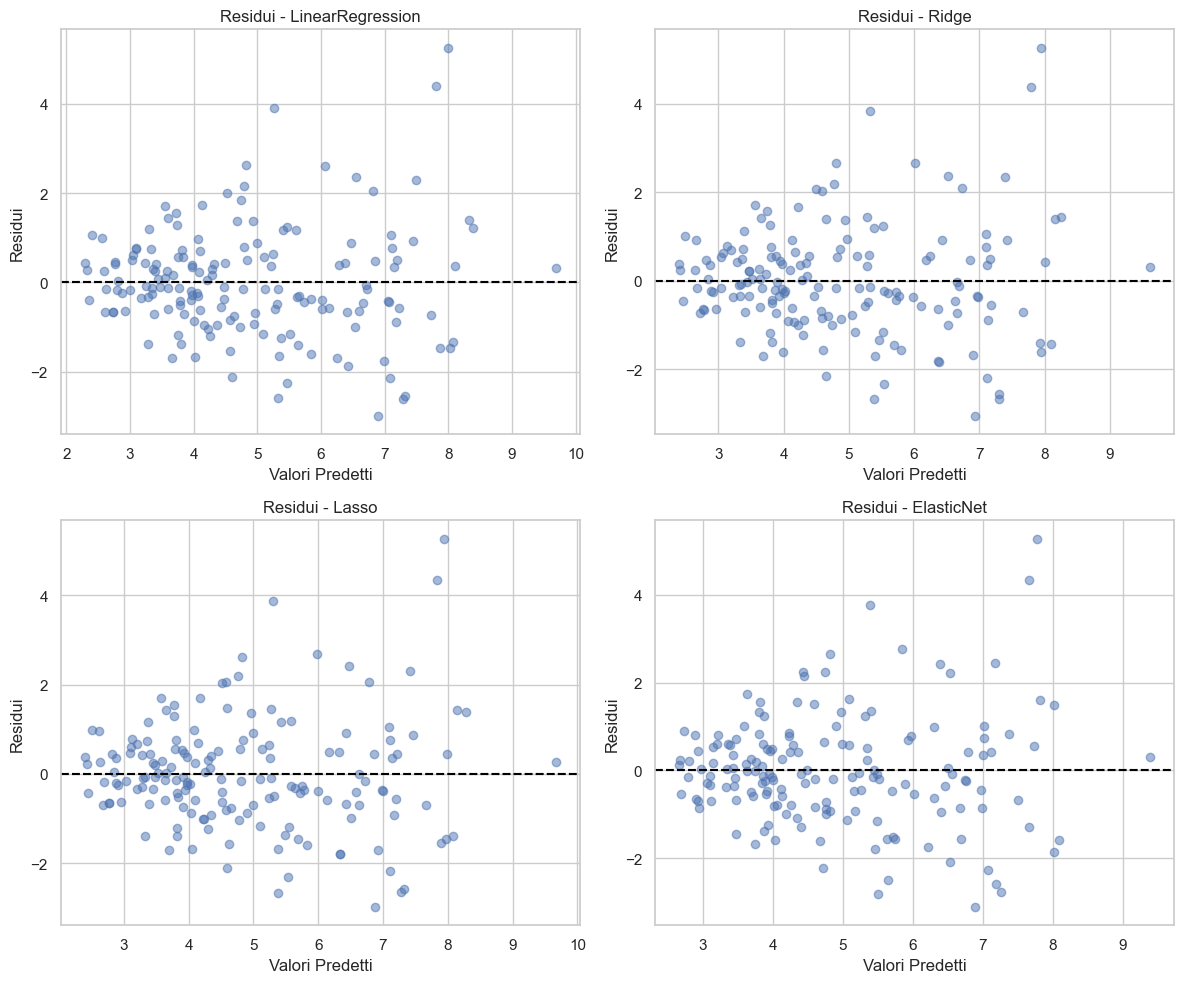

In [51]:
# Imposta il tema di Seaborn
sns.set_theme(style="whitegrid")

# Crea una griglia 2x2 per i plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Itera sui modelli e genera i residui plot
for idx, (name, model) in enumerate(models.items()):

    # Effettua le predizioni
    y_pred = model.predict(X_test)
    
    # Calcola i residui
    residuals = y_test - y_pred
    
    # Crea il residuo plot
    sns.residplot(x=y_pred, y=residuals,  ax=axes[idx], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
    axes[idx].set_title(f'Residui - {name}')
    axes[idx].set_xlabel('Valori Predetti')
    axes[idx].set_ylabel('Residui')
    axes[idx].axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

Possiamo osservare che:
* I grafici non mostrano pattern sistematici, il che suggerisce che  la relazione tra variabili predittive e target sia stata catturata in modo relativamente lineare.
* Tutti i modelli mostrano una certa eteroscedasticità (varianza dei residui non costante), visibile dall’allargamento del "funnel" man mano che aumentano i valori predetti. Questo potrebbe indicare che i modelli non catturano perfettamente la struttura nei dati.

### 7.2 Test di Durbin-Watson

Questo test è specificamente progettato per rilevare l'autocorrelazione nei residui di un modello di regressione. Il valore del test varia tra 0 e 4, dove un valore vicino a 2 indica nessuna autocorrelazione, valori inferiori a 2 indicano autocorrelazione positiva e valori superiori a 2 indicano autocorrelazione negativa.

In [52]:
for idx, (name, model) in enumerate(models.items()):

    # Effettua le predizioni
    y_pred = model.predict(X_test)
    
    # Calcola i residui
    residuals = y_test - y_pred

    dw_test = sm.stats.durbin_watson(residuals)
    print(f"Durbin-Watson per la {name}:", dw_test)

Durbin-Watson per la LinearRegression: 2.087321557028035
Durbin-Watson per la Ridge: 2.087176550702819
Durbin-Watson per la Lasso: 2.0780187421399403
Durbin-Watson per la ElasticNet: 2.094653904175648


Tutti i quattro i modelli registrano un valore vicino al 2, ovvero nessuna autocorrelazione. Quindi, tutti e quattro i modelli soddisfano la condizione di indipendenza dei residui.

### 7.3 Q-Q plot

Il Q-Q plot (Quantile-Quantile plot) è uno strumento grafico fondamentale nell'analisi dei residui di un modello di regressione, utilizzato per verificare l'assunzione di **normalità** degli errori. Un Q-Q plot confronta i quantili empirici dei residui standardizzati con i quantili teorici di una distribuzione normale. Se i residui seguono una distribuzione normale, i punti del grafico si allineano lungo una retta diagonale di 45 gradi (y = x) . Deviazioni significative da questa linea indicano una possibile violazione dell'assunzione di normalità.

Il seguente codice crea il Q-Q plot per ognuno dei quattro modelli tramite la libreria `seaborn`. Il Q-Q plot confronta i quantili della distribuzione dei residui con quelli della distribuzione normale standard. Per cui, prima della creazione del plot, i valori dei residui vengono trasformati su quella scala in modo tale da essere resi confrontabili.

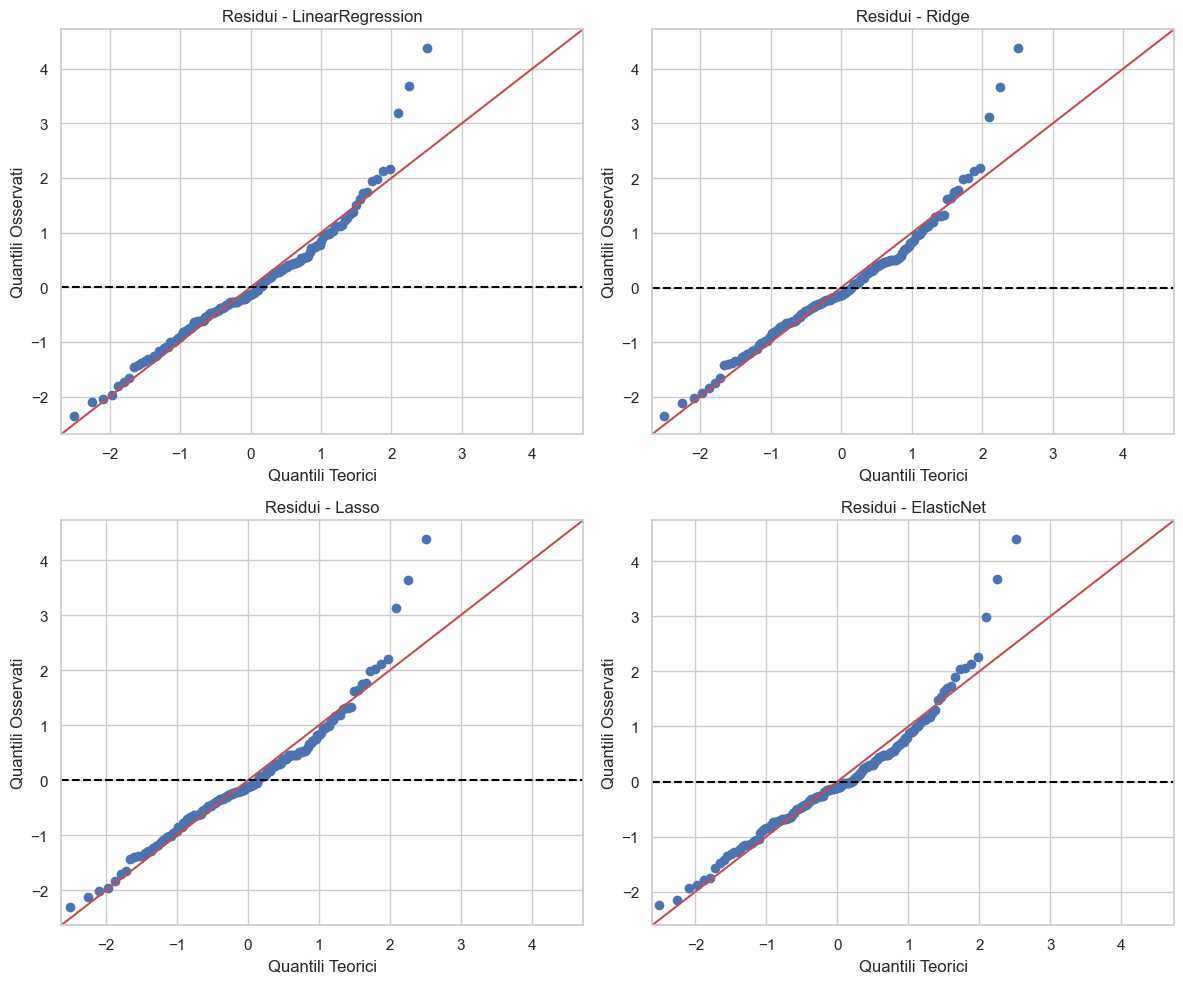

In [53]:
# Imposta il tema di Seaborn
sns.set_theme(style="whitegrid")

# Crea una griglia 2x2 per i plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Itera sui modelli e genera i residui plot
for idx, (name, model) in enumerate(models.items()):

    # Effettua le predizioni
    y_pred = model.predict(X_test)
    
    # Calcola i residui
    residuals = y_test - y_pred

    # Standardizza i residui
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    
    # Crea il residuo plot
    sm.qqplot(standardized_residuals, line='45', ax=axes[idx])
    axes[idx].set_title(f'Residui - {name}')
    axes[idx].set_xlabel('Quantili Teorici')
    axes[idx].set_ylabel('Quantili Osservati')
    axes[idx].axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

Tutti e quattro i modelli mostrano una buona aderenza alla linea rossa nella parte centrale del grafico, segnalando che la maggior parte dei residui segue una distribuzione normale. Tuttavia, alle estremità di tutti e quattro i grafici, si notano deviazioni verso l'alto, soprattutto per valori elevati di quantili teorici (cioè nelle code destre). Questo indica che ci sono alcuni outlier o residui che si discostano dalla normalità, presentando code più pesanti della normale teorica. Non emergono differenze significative tra i modelli.

### 7.4 Conclusioni

L'analisi dei residui non fa emergere differenze significative tra i quattro modelli, suggerendo nuovamente che le tecniche di regolarizzazione non apportano miglioramenti significativi. Tutti e quattro i modelli presentano pattern simili nella distribuzione dei residui e rispettano tre delle quattro ipotesi fondamentali della regressione lineare. In tutti i casi, infatti, si osserva la presenza di eteroschedasticità.

## 8. Curva di apprendimento

In questa sezione verrà tracciata la curva di apprendimento per ogni modello di regressione testato. La curva di apprendimento è un grafico che mostra come cambiano le prestazioni di un modello in base alla quantità di dati utilizzati per l'addestramento. Vengono tracciate due curve: una che rappresenta le prestazioni sui dati di addestramento e una sui dati di validazione. Questo strumento è utile per capire come il modello apprende e se riesce a generalizzare bene, perché può mettere in evidenza sia la presenza di overfitting che di underfitting. 

La curva fa interpretata come segue:

* **Overfitting**: la curva di addestramento mostra un errore basso, mentre quella di validazione mostra un errore elevato.

* **Underfitting**: entrambe le curve mostrano errori elevati.

* **Buona generalizzazione**: entrambe le curve convergono verso un errore basso.

Nel codice sottostante, i imodelli vengono reinizializzati perché durante il calcolo della curva di apprendimento verranno addestrati da zero per valutarne le performance all'aumentare degli esempi di addestramento. Questo comporta anche la necessità di garantire il preprocessing iniziale ogni volta. Questo viene attuato tramite la classe `Pipeline` che permette di impostare in unico flusso un "preprocessor" e il modello che riceverà automaticamente i dati preprocessati. Il preprocessor è costituito da un `ColumnTransformer`, in cui viene inizializzato lo `StandardScaler` che viene opportunamente impostato per effettuare lo scaling solo sulle colonne numeriche. Tramite la classe `TransformedTargetRegressor` viene anche operato lo scaling della variabile target

In [54]:
# Inizializzazione dei modelli
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=10),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.1)
}

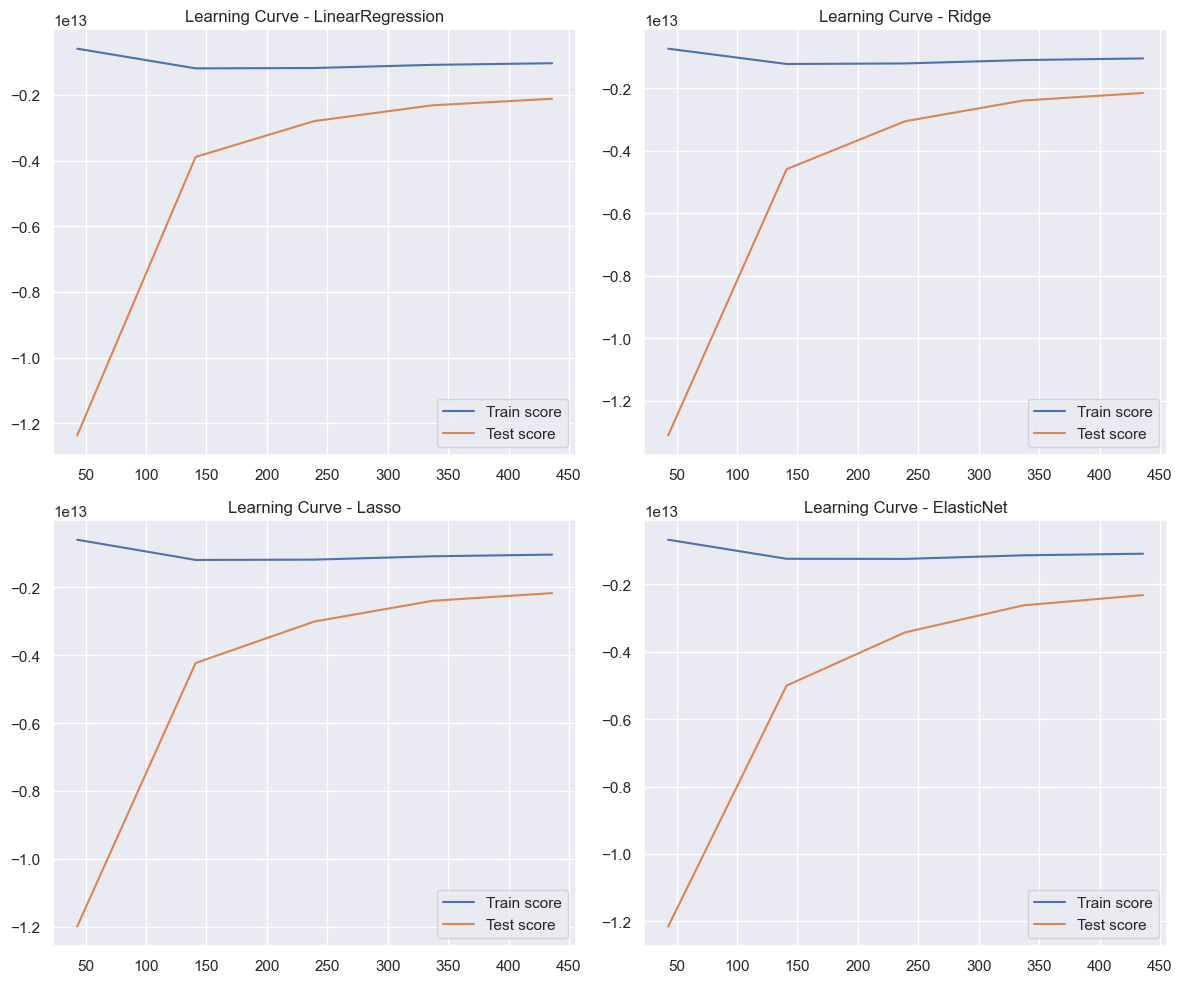

In [55]:
# Imposta il tema di Seaborn
sns.set_theme()

# Crea una griglia 2x2 per i plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Itera sui modelli e genera i residui plot
for idx, (name, model) in enumerate(models.items()):

    # Inizializzazione del preprocessor con un trasformatore che setta lo scaling solo per le colonne numeriche, 
    # presenti nella variabile 'to_std'
    preprocessor = ColumnTransformer(
    transformers=[
            ('num', StandardScaler(), to_std)
        ],
        remainder='passthrough'  # Lascia inalterate le altre colonne
    )
    
    # Creazione della pipeline con il preprocessor e il modello
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Creazione del regressore con lo scaling della variabile del target
    model_to_estimate = TransformedTargetRegressor(
        regressor=model_pipeline,
        func=lambda y: y / 1e6,       # Funzione di trasformazione del target
        inverse_func=lambda y: y * 1e6  # Funzione inversa per riportare il target alla scala originale
    )

    train_sizes, train_scores, test_scores = learning_curve(
                                                            estimator=model_to_estimate, 
                                                            X=X, 
                                                            y=y, 
                                                            scoring="neg_mean_squared_error", 
                                                            random_state=RANDOM_SEED
                                        )

    #calcoliamo la media dei punteggi
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    
    # Crea il residuo plot
    axes[idx].plot(train_sizes, train_scores.mean(axis=1), label="Train score")
    axes[idx].plot(train_sizes, test_scores.mean(axis=1), label="Test score")
    axes[idx].legend(loc="best")
    axes[idx].set_title(f'Learning Curve - {name}')


plt.tight_layout()
plt.show()

### 8.1 Analisi dei modelli

#### **LinearRegression**
L’errore di training si mantiene basso e stabile, mentre l’errore di validazione diminuisce con l’aumentare del numero di dati, indicando una buona capacità di generalizzazione. Si osserva un miglioramento rapido delle prestazioni fino a circa 150 esempi, oltre i quali la curva di validazione continua a migliorare in modo più graduale, convergendo verso un errore contenuto. Tuttavia, la distanza residua tra la curva di validazione e quella di training segnala la presenza di un moderato overfitting.

#### **Ridge**
Il comportamento è simile a regressione lineare pura, con un trend della curva di validazione comparabile ma che poi converge allo stesso valore di errore della regressione semplice.

#### **Lasso**
Lasso registra un comportamento simile a quello di Ridge e della regressione lineare pura.

#### **ElasticNet**

ElasticNet ha un comportamente non tanto distante dagli altri modelli. Tuttavia in questo caso, il grafico mostra una crescita della curva di addestramento leggermente meno rapida e che converge verso un valore minore rispetto agli altri modelli.


II quattro grafici evidenziano un lieve overfitting per tutti i modelli, con le curve di validazione che tendono a stabilizzarsi a una certa distanza da quelle di addestramento. Le differenze tra i modelli sono trascurabili, a conferma del fatto che le tecniche di regolarizzazione impiegate non producono effetti rilevanti sulle prestazioni.